# Score Table

In [41]:
from jaxgeometry.manifolds import *
from jaxgeometry.manifolds.Ellipsoid2 import Ellipsoid2
from jaxgeometry.setup import dts, jacfwdx
from jaxgeometry.statistics.score_matching import diffusion_mean
import jaxgeometry.statistics as jstat
import jaxgeometry.stochastics as jstoch
import jax.numpy as jnp
import haiku as hk
import jax
from jax import vmap

import pandas as pd

from ManLearn.VAE.VAE_MNIST import model as mnist_model
from ManLearn.VAE.VAE_MNIST import model_encoder as mnist_encoder
from ManLearn.VAE.VAE_MNIST import model_decoder as mnist_decoder
from ManLearn.VAE.VAE_MNIST import VAEOutput as mnist_output

from ManLearn.VAE.VAE_SVHN import model as svhn_model
from ManLearn.VAE.VAE_SVHN import model_encoder as svhn_encoder
from ManLearn.VAE.VAE_SVHN import model_decoder as svhn_decoder
from ManLearn.VAE.VAE_SVHN import VAEOutput as svhn_output

from ManLearn.VAE.VAE_CelebA import model as celeba_model
from ManLearn.VAE.VAE_CelebA import model_encoder as celeba_encoder
from ManLearn.VAE.VAE_CelebA import model_decoder as celeba_decoder
from ManLearn.VAE.VAE_CelebA import VAEOutput as celeba_output

from ManLearn.train_MNIST import load_dataset as load_mnist
from ManLearn.train_SVHN import load_dataset as load_svhn
from ManLearn.train_CelebA import load_dataset as load_celeba
from ManLearn.model_loader import load_model

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

from jaxgeometry.statistics.score_matching import model_loader
from scores import models

In [42]:
loss_type = 'vsm'

In [43]:
def get_coords(M, Fx):
    chart = M.centered_chart(Fx)
    return (M.invF((Fx,chart)),chart)

def to_TM(M, Fx,v):
    x = get_coords(Fx)
#     return jnp.dot(M.JF(x),jnp.dot(M.invJF((Fx,x[1])),v))
    JFx = M.JF(x)
    return jnp.dot(JFx,jnp.linalg.lstsq(JFx,v)[0])

def to_TMx(M, Fx,v):

    x = get_coords(M, Fx)

    return jnp.dot(M.invJF((Fx,x[1])),v)

# Euclidean

## Defining Manifold and Loading Score

In [68]:
N = 50

In [69]:
M = Euclidean(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = (jnp.zeros(2), jnp.zeros(1))

using M.Exp for Logarithm


In [70]:
file_path = 'scores/R'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [71]:
loss = jnp.load('scores/R'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  2220


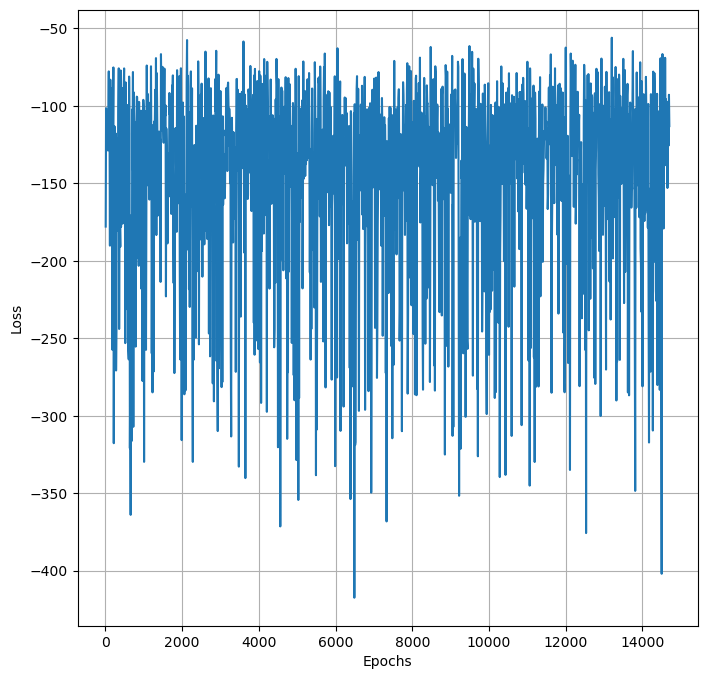

In [67]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [265]:
xs = pd.read_csv('Data/R'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/R'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [266]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [267]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 2.885027e+02 | T: ((Array([ 0.21127088, -0.01086277, -0.10348484, -0.00677376,  0.00568383,
       -0.1591781 ,  0.05061714, -0.13262783,  0.08135431, -0.22801885,
       -0.00415839,  0.1709886 , -0.13562922, -0.04596922,  0.00693661,
        0.09484188,  0.07191613,  0.09927194,  0.03728437,  0.08506462,
        0.07350846, -0.08834033,  0.05262659, -0.05154429,  0.02554498,
        0.06773102,  0.12670974,  0.00505038, -0.01562493,  0.07221521,
        0.06255835, -0.08182061,  0.01519844,  0.14262749,  0.05831639,
        0.20837349,  0.11152188,  0.01231895,  0.10338337,  0.03118102,
        0.05298587, -0.00789808,  0.00052956, -0.01627529, -0.08343912,
        0.01600937, -0.18403749, -0.02488659,  0.03633674, -0.12077427],      dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 2.600248e+02 | T: ((Array([ 0.20133404, -0.00159725, -0.09357826, -0.00254662, -0.00292924,
       -0.14925033,  0.04078381, -0.12270777,  0.07146609, 

Step 7 | T: 1.582806e+02 | T: ((Array([ 1.44933999e-01,  1.06270816e-02, -3.93264294e-02, -1.58854877e-03,
       -1.04992394e-03, -9.34638083e-02, -7.33720744e-03, -6.74634948e-02,
        1.86469145e-02, -1.61539793e-01,  9.37827397e-04,  1.05105132e-01,
       -7.03899488e-02,  1.08626271e-02, -3.00040888e-03,  3.11799794e-02,
        1.01478230e-02,  3.53647135e-02, -1.55043770e-02,  2.20573340e-02,
        1.15607046e-02, -2.50329003e-02, -5.85031509e-03,  6.88345404e-03,
       -1.81545019e-02,  6.48459001e-03,  6.17310479e-02, -6.32903539e-05,
        1.53818708e-02,  1.04124565e-02,  2.07789615e-03, -1.90001447e-02,
       -1.33954696e-02,  7.72470906e-02, -1.40942214e-03,  1.42062590e-01,
        4.70575206e-02, -1.04216048e-02,  3.92712168e-02, -1.76581889e-02,
       -5.57951815e-03, -1.72012369e-03,  5.58171421e-03,  1.58698708e-02,
       -2.04890817e-02, -1.40949190e-02, -1.17971435e-01,  1.90544706e-02,
       -1.59255248e-02, -5.59495166e-02], dtype=float32), Array(0.27

Step 17 | T: 9.943575e+01 | T: ((Array([ 0.07173326, -0.00780415,  0.01611141,  0.00321934,  0.00173009,
       -0.02538949, -0.02396966, -0.00391442, -0.02581846, -0.08717567,
        0.0001944 ,  0.03563518, -0.00622643,  0.02259883,  0.00370492,
       -0.02038884, -0.02781525, -0.01810236, -0.01352892, -0.02458853,
       -0.02760583,  0.02384329, -0.02495687,  0.0257517 ,  0.00014791,
       -0.02808466, -0.00030049,  0.00070181, -0.0077044 , -0.02778022,
       -0.02779442,  0.02628167,  0.00905882,  0.01192391, -0.02697693,
        0.06907489, -0.01081401,  0.00892983, -0.01580169, -0.00668376,
       -0.02511785,  0.00404063, -0.00377573, -0.00736857,  0.02573678,
        0.00880303, -0.04699678,  0.00100876, -0.01253634,  0.00482904],      dtype=float32), Array(0.35096258, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 9.649280e+01 | T: ((Array([ 6.6046216e-02, -7.1100062e-03,  1.9044960e-02,  2.4583836e-03,
        9.7396318e-05, -2.0531038e-02, -2.2572882e-02,  2.

Step 27 | T: 7.957869e+01 | T: ((Array([ 0.02698898,  0.0040347 ,  0.02948227, -0.00032345, -0.00217301,
        0.00923902, -0.00423096,  0.02246628, -0.02521224, -0.04003702,
        0.00226116, -0.00167114,  0.02123374,  0.00168829, -0.00339442,
       -0.02836714, -0.02076017, -0.02866167,  0.00691439, -0.02644112,
       -0.02164724,  0.02837099, -0.00605736,  0.00676421,  0.00932014,
       -0.01816681, -0.02407123, -0.001385  , -0.00090201, -0.02093102,
       -0.01445712,  0.02657819,  0.00027   , -0.01760868, -0.01104104,
        0.02476548, -0.02784479, -0.00269541, -0.02864172,  0.00965844,
       -0.00638159, -0.00155451,  0.00318902, -0.00165205,  0.02710383,
        0.00120606, -0.00673752, -0.00851452,  0.00749907,  0.02650551],      dtype=float32), Array(0.40337053, dtype=float32)), Array([0.], dtype=float32))
Step 28 | T: 7.839140e+01 | T: ((Array([ 2.3849636e-02,  4.6153511e-03,  2.9303035e-02,  3.9116805e-04,
       -1.2796815e-03,  1.1211601e-02, -2.3214626e-03,  2.

Step 37 | T: 7.086517e+01 | T: ((Array([ 0.00389221,  0.00147856,  0.0216743 ,  0.00023312,  0.00289485,
        0.02047767,  0.0079844 ,  0.02531787, -0.01000025, -0.01390014,
       -0.00170237, -0.01588658,  0.02511399, -0.00798916,  0.00299428,
       -0.01715149, -0.00398183, -0.01899758,  0.00774169, -0.01217595,
       -0.00502849,  0.01532254,  0.00727018, -0.00646161, -0.00023932,
       -0.00122416, -0.0245242 ,  0.0025917 ,  0.00459402, -0.00417887,
        0.00208186,  0.01169379, -0.00321154, -0.0235229 ,  0.00456161,
        0.00221174, -0.02270016, -0.00112446, -0.02047042,  0.00419511,
        0.00712724,  0.00139643, -0.00127407,  0.00472431,  0.01263821,
       -0.00355601,  0.01089848,  0.00094725,  0.00732835,  0.02512573],      dtype=float32), Array(0.44010204, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 7.027607e+01 | T: ((Array([ 2.4414747e-03,  7.6808280e-04,  2.0463746e-02, -1.6088446e-04,
        2.6049893e-03,  2.0774251e-02,  8.3243139e-03,  2.

Step 46 | T: 6.660488e+01 | T: ((Array([-5.2502961e-03, -1.8001265e-03,  1.0734793e-02,  6.9704372e-04,
       -7.5307512e-04,  1.9956594e-02,  6.8759462e-03,  1.9218650e-02,
        8.8050426e-04, -2.0046330e-03,  1.8740525e-03, -1.7615652e-02,
        1.9631047e-02, -4.7626975e-03,  3.6151061e-05, -5.5785934e-03,
        4.8654787e-03, -7.6275663e-03,  7.4170274e-04, -8.7531435e-04,
        4.2670700e-03,  3.7702406e-03,  7.3178182e-03, -6.3960180e-03,
       -3.2705795e-03,  6.2291678e-03, -1.7073266e-02, -9.8718051e-04,
       -1.3886631e-04,  4.7560516e-03,  7.3797917e-03,  6.3739100e-04,
        1.7998542e-03, -1.9318145e-02,  7.7622817e-03, -6.4498824e-03,
       -1.2646716e-02,  2.6999500e-03, -9.4329724e-03, -2.3251926e-03,
        7.3808627e-03, -2.3395773e-04,  1.3380542e-03,  2.8558780e-04,
        1.4059257e-03,  1.3361898e-03,  1.5364788e-02,  4.1729128e-03,
        2.0548532e-04,  1.6730089e-02], dtype=float32), Array(0.46472767, dtype=float32)), Array([0.], dtype=float3

Step 56 | T: 6.364911e+01 | T: ((Array([-8.3134631e-03,  1.0806536e-03,  1.7798592e-03,  7.4636133e-05,
        5.6287297e-04,  1.4842414e-02,  1.2488302e-03,  1.0756122e-02,
        5.4416498e-03,  3.7436853e-03, -1.7805607e-05, -1.4195993e-02,
        1.1457701e-02,  1.0654086e-03, -1.3422636e-04,  2.1930682e-03,
        6.1657098e-03,  7.9913158e-04, -2.5261776e-03,  4.7536022e-03,
        6.1620795e-03, -2.8903892e-03,  2.0151956e-03, -1.0557689e-03,
        3.3981906e-04,  5.9187119e-03, -8.0818431e-03,  8.9963048e-04,
       -1.0463382e-03,  6.1690216e-03,  5.0816122e-03, -4.3284008e-03,
        1.4615919e-03, -1.1820863e-02,  3.9727441e-03, -9.0577705e-03,
       -3.3165244e-03,  6.4330612e-05, -5.6235591e-04, -1.8526706e-03,
        2.1498166e-03,  7.3494372e-04, -1.2277742e-05, -1.2086764e-03,
       -4.0208660e-03,  1.7731532e-03,  1.4194921e-02,  6.4608315e-04,
       -2.5579261e-03,  7.4807392e-03], dtype=float32), Array(0.48637748, dtype=float32)), Array([0.], dtype=float3

Step 64 | T: 6.200091e+01 | T: ((Array([-8.0772573e-03,  1.2367761e-03, -1.7415558e-03,  6.3680159e-04,
        1.0414632e-03,  1.0230544e-02, -1.3388706e-03,  5.3343899e-03,
        4.9272412e-03,  5.2424483e-03,  4.3746346e-05, -1.0327386e-02,
        6.0318089e-03,  2.7483054e-03,  1.1568508e-03,  4.2597596e-03,
        3.8810014e-03,  3.5918669e-03, -1.1345873e-03,  4.9810554e-03,
        4.1484097e-03, -3.9314805e-03, -9.2651480e-04,  1.8553631e-03,
        1.8980552e-03,  3.0200279e-03, -2.7857537e-03,  8.4394414e-04,
        9.0128963e-04,  3.9339121e-03,  1.7063005e-03, -4.0845075e-03,
       -3.6961152e-04, -6.4729103e-03,  5.3139869e-04, -8.5382164e-03,
        1.0212935e-03, -4.6865951e-04,  2.8274078e-03,  6.6915888e-04,
       -8.4527984e-04,  1.1861519e-04,  4.0214098e-04,  6.8604347e-04,
       -4.1007688e-03, -1.6653928e-04,  1.1473537e-02, -9.9445973e-04,
       -8.9495047e-04,  2.3928562e-03], dtype=float32), Array(0.500928, dtype=float32)), Array([0.], dtype=float32)

Step 73 | T: 6.059629e+01 | T: ((Array([-6.6500059e-03, -1.4957797e-05, -2.7067855e-03,  2.9055963e-04,
        4.1969171e-05,  5.9098843e-03, -1.3357700e-03,  1.4279505e-03,
        2.7097929e-03,  5.3037386e-03,  8.6502259e-04, -6.3245213e-03,
        1.9769750e-03,  1.8459869e-03,  2.9738073e-04,  3.8266373e-03,
        1.0787384e-03,  3.8170612e-03,  9.0321456e-04,  3.1854014e-03,
        1.3816138e-03, -2.6854756e-03, -1.4082545e-03,  2.2902377e-03,
        9.3443139e-04,  2.7751923e-04,  6.7591120e-04,  1.9867846e-05,
        1.0812124e-03,  1.1360138e-03, -6.1975094e-04, -2.0114344e-03,
        6.3867730e-05, -2.2022699e-03, -1.1577981e-03, -6.8790638e-03,
        2.9426422e-03,  7.9403655e-04,  3.6522485e-03,  1.5983187e-03,
       -1.4118381e-03,  6.5940729e-04,  6.0630881e-04,  1.1644231e-03,
       -2.2148807e-03, -1.1006158e-04,  8.1636477e-03, -9.8702105e-05,
        1.0793438e-03, -6.3926762e-04], dtype=float32), Array(0.5153236, dtype=float32)), Array([0.], dtype=float32

Step 82 | T: 5.950627e+01 | T: ((Array([-4.9151336e-03,  2.9223762e-04, -1.9822279e-03,  5.5598834e-04,
        5.0591712e-04,  2.9142075e-03, -4.3361259e-05, -4.5097264e-04,
        7.4751861e-04,  4.6128957e-03,  2.6166893e-04, -3.2798494e-03,
       -1.0241177e-04,  3.8523562e-04,  2.5000694e-04,  2.3129033e-03,
       -4.0868769e-04,  2.6411868e-03,  1.3112045e-03,  1.2334881e-03,
       -2.3919453e-04, -8.5639360e-04, -3.0831396e-04,  1.1688810e-03,
       -6.1090665e-05, -7.6075789e-04,  2.0357969e-03,  6.2242959e-04,
        1.6332720e-04, -3.7810730e-04, -9.4202865e-04, -4.1149848e-05,
        8.5258239e-04,  2.2748727e-04, -8.3068054e-04, -4.9925419e-03,
        2.9051341e-03,  6.9250731e-04,  2.8366200e-03,  7.4784155e-04,
       -3.5218100e-04,  2.9995610e-04,  2.7443512e-04,  2.6051907e-04,
       -2.5292742e-04,  7.8378042e-04,  5.3443452e-03,  9.2547998e-04,
        1.2847028e-03, -1.5628975e-03], dtype=float32), Array(0.5281995, dtype=float32)), Array([0.], dtype=float32

Step 91 | T: 5.863550e+01 | T: ((Array([-3.3323029e-03,  6.8754586e-04, -8.1547315e-04,  3.6164408e-04,
        5.5549532e-04,  1.1341685e-03,  8.4036007e-04, -9.7578589e-04,
       -1.9790002e-04,  3.7111426e-03,  4.2028748e-04, -1.2601928e-03,
       -8.0856564e-04, -1.6748924e-04,  6.3413539e-04,  9.5010677e-04,
       -5.6931656e-04,  1.3274750e-03,  6.6158967e-04,  8.2447179e-05,
       -5.5138679e-04,  4.4255223e-04,  6.7172426e-04,  1.9572038e-04,
        1.4968650e-04, -5.1389291e-04,  2.1300849e-03,  4.6589927e-04,
        2.2493431e-04, -5.6753494e-04, -2.3988509e-04,  9.8703906e-04,
        5.0933613e-04,  1.2777169e-03,  1.2208635e-04, -3.3207785e-03,
        2.0671468e-03,  2.0953031e-04,  1.6348184e-03,  7.2978604e-05,
        6.3895382e-04,  5.3506892e-04,  5.6738709e-04,  1.7089301e-04,
        8.6256425e-04,  6.0790160e-04,  3.2594015e-03,  7.5515767e-04,
        5.6139124e-04, -1.3320097e-03], dtype=float32), Array(0.53991055, dtype=float32)), Array([0.], dtype=float3

In [273]:
mu_opt, T_opt = M.mlxt_hk(X_obs)

In [274]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0012 0.0353 0.0089 0.0048 0.0132 0.0032 -0.0298 0.0110 0.0105 0.0288 -0.0126 -0.0153 0.0146 -0.0088 -0.0063 -0.0376 -0.0095 -0.0318 0.0167 -0.0081 -0.0207 -0.0215 -0.0321 -0.0332 0.0308 -0.0355 0.0199 0.0135 0.0445 -0.0262 -0.0351 0.0549 0.0410 -0.0005 0.0086 0.0003 0.0126 -0.0272 0.0276 -0.0028 0.0224 -0.0587 -0.0026 -0.0140 -0.0195 0.0183 0.0083 -0.0010 0.0332 -0.0152 )
T = 0.5692


In [275]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgex[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( -0.0022 0.0004 0.0000 0.0005 0.0003 0.0003 0.0009 -0.0008 -0.0003 0.0029 0.0006 -0.0002 -0.0008 0.0000 0.0004 0.0002 -0.0002 0.0005 0.0002 -0.0002 -0.0002 0.0009 0.0009 -0.0000 0.0006 0.0001 0.0017 0.0003 0.0006 -0.0002 0.0004 0.0012 0.0003 0.0015 0.0007 -0.0021 0.0013 0.0004 0.0008 0.0002 0.0009 0.0004 0.0004 0.0005 0.0011 0.0003 0.0020 0.0003 0.0002 -0.0008 )
T = 0.5495


In [276]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[0]), ")")
print(f"T = {T_opt:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0004 0.0306 0.0177 -0.0048 0.0087 0.0059 -0.0248 0.0047 0.0045 0.0306 -0.0084 -0.0186 0.0145 -0.0121 0.0009 -0.0331 -0.0134 -0.0227 0.0164 -0.0126 -0.0186 -0.0404 -0.0267 -0.0271 0.0278 -0.0333 0.0136 0.0193 0.0387 -0.0244 -0.0315 0.0504 0.0437 -0.0034 -0.0004 0.0020 0.0114 -0.0238 0.0281 -0.0034 0.0212 -0.0504 -0.0025 -0.0191 -0.0179 0.0260 0.0064 0.0018 0.0354 -0.0123 )
T = 0.5018


In [277]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_sm[0][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[0]-mu_bridgex[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.00076 
 -T error = 0.06738
Bridge Diffusion mean: 
 -mean error = 0.00325 
 -T error = 0.04770


In [278]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

KeyboardInterrupt: 

In [189]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

Step 0 | T: 1.090680e+01 | T: ((Array([0.02904129, 0.0880188 ], dtype=float32), Array(0.20999993, dtype=float32)), Array([0.], dtype=float32))
Step 1 | T: 9.846338e+00 | T: ((Array([0.03286598, 0.07815763], dtype=float32), Array(0.21992855, dtype=float32)), Array([0.], dtype=float32))
Step 2 | T: 8.945294e+00 | T: ((Array([0.03153133, 0.06853775], dtype=float32), Array(0.22974607, dtype=float32)), Array([0.], dtype=float32))
Step 3 | T: 8.176117e+00 | T: ((Array([0.02823931, 0.05926494], dtype=float32), Array(0.2394186, dtype=float32)), Array([0.], dtype=float32))
Step 4 | T: 7.517627e+00 | T: ((Array([0.0247399 , 0.05044355], dtype=float32), Array(0.24891779, dtype=float32)), Array([0.], dtype=float32))
Step 5 | T: 6.952074e+00 | T: ((Array([0.02222239, 0.04217086], dtype=float32), Array(0.25822055, dtype=float32)), Array([0.], dtype=float32))
Step 6 | T: 6.464427e+00 | T: ((Array([0.02122806, 0.03453141], dtype=float32), Array(0.26730862, dtype=float32)), Array([0.], dtype=float32))


Step 57 | T: 2.463132e+00 | T: ((Array([0.02576311, 0.0303678 ], dtype=float32), Array(0.48828152, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.454818e+00 | T: ((Array([0.02574349, 0.02992646], dtype=float32), Array(0.49015784, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.446812e+00 | T: ((Array([0.02577924, 0.0294837 ], dtype=float32), Array(0.49200046, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.439095e+00 | T: ((Array([0.02586135, 0.02904472], dtype=float32), Array(0.4938109, dtype=float32)), Array([0.], dtype=float32))
Step 61 | T: 2.431653e+00 | T: ((Array([0.02597648, 0.02861421], dtype=float32), Array(0.4955905, dtype=float32)), Array([0.], dtype=float32))
Step 62 | T: 2.424470e+00 | T: ((Array([0.02610889, 0.02819631], dtype=float32), Array(0.49734062, dtype=float32)), Array([0.], dtype=float32))
Step 63 | T: 2.417531e+00 | T: ((Array([0.02624233, 0.02779466], dtype=float32), Array(0.49906245, dtype=float32)), Array([0.], dtype=floa

Step 17 | T: 3.824954e+00 | T: ((Array([ 0.02660039, -0.00196951], dtype=float32), Array(0.35114065, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 3.713172e+00 | T: ((Array([ 0.02542573, -0.0017213 ], dtype=float32), Array(0.35730565, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 3.612167e+00 | T: ((Array([ 0.02446746, -0.00110045], dtype=float32), Array(0.36324832, dtype=float32)), Array([0.], dtype=float32))
Step 20 | T: 3.520661e+00 | T: ((Array([ 0.02383156, -0.00015956], dtype=float32), Array(0.3689756, dtype=float32)), Array([0.], dtype=float32))
Step 21 | T: 3.437550e+00 | T: ((Array([0.02356683, 0.0010513 ], dtype=float32), Array(0.37449467, dtype=float32)), Array([0.], dtype=float32))
Step 22 | T: 3.361882e+00 | T: ((Array([0.02366693, 0.00248492], dtype=float32), Array(0.37981284, dtype=float32)), Array([0.], dtype=float32))
Step 23 | T: 3.292835e+00 | T: ((Array([0.02407983, 0.00409707], dtype=float32), Array(0.38493755, dtype=float32)), Array([0.], d

Step 76 | T: 2.344785e+00 | T: ((Array([0.02603449, 0.02484197], dtype=float32), Array(0.5193189, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 2.340248e+00 | T: ((Array([0.02603852, 0.02479569], dtype=float32), Array(0.52074045, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 2.335831e+00 | T: ((Array([0.02606361, 0.02477044], dtype=float32), Array(0.52214557, dtype=float32)), Array([0.], dtype=float32))
Step 79 | T: 2.331530e+00 | T: ((Array([0.02610498, 0.02476456], dtype=float32), Array(0.52353466, dtype=float32)), Array([0.], dtype=float32))
Step 80 | T: 2.327340e+00 | T: ((Array([0.02615645, 0.02477632], dtype=float32), Array(0.5249082, dtype=float32)), Array([0.], dtype=float32))
Step 81 | T: 2.323257e+00 | T: ((Array([0.02621129, 0.02480393], dtype=float32), Array(0.5262666, dtype=float32)), Array([0.], dtype=float32))
Step 82 | T: 2.319278e+00 | T: ((Array([0.02626297, 0.0248456 ], dtype=float32), Array(0.52761024, dtype=float32)), Array([0.], dtype=float

Step 36 | T: 2.764360e+00 | T: ((Array([0.02578018, 0.02685268], dtype=float32), Array(0.43721628, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 2.740841e+00 | T: ((Array([0.02540632, 0.02804244], dtype=float32), Array(0.44036356, dtype=float32)), Array([0.], dtype=float32))
Step 38 | T: 2.718767e+00 | T: ((Array([0.02515764, 0.02910459], dtype=float32), Array(0.44341454, dtype=float32)), Array([0.], dtype=float32))
Step 39 | T: 2.698013e+00 | T: ((Array([0.02505032, 0.03003829], dtype=float32), Array(0.4463741, dtype=float32)), Array([0.], dtype=float32))
Step 40 | T: 2.678470e+00 | T: ((Array([0.02508324, 0.03084433], dtype=float32), Array(0.44924676, dtype=float32)), Array([0.], dtype=float32))
Step 41 | T: 2.660036e+00 | T: ((Array([0.02523986, 0.03152495], dtype=float32), Array(0.45203698, dtype=float32)), Array([0.], dtype=float32))
Step 42 | T: 2.642621e+00 | T: ((Array([0.0254915 , 0.03208365], dtype=float32), Array(0.45474887, dtype=float32)), Array([0.], dtype=flo

Step 94 | T: 2.278385e+00 | T: ((Array([0.02615245, 0.02584172], dtype=float32), Array(0.54270554, dtype=float32)), Array([0.], dtype=float32))
Step 95 | T: 2.275468e+00 | T: ((Array([0.02615133, 0.02592532], dtype=float32), Array(0.5438861, dtype=float32)), Array([0.], dtype=float32))
Step 96 | T: 2.272616e+00 | T: ((Array([0.02615925, 0.02600458], dtype=float32), Array(0.54505587, dtype=float32)), Array([0.], dtype=float32))
Step 97 | T: 2.269826e+00 | T: ((Array([0.02617444, 0.02607897], dtype=float32), Array(0.546215, dtype=float32)), Array([0.], dtype=float32))
Step 98 | T: 2.267097e+00 | T: ((Array([0.02619449, 0.02614806], dtype=float32), Array(0.5473637, dtype=float32)), Array([0.], dtype=float32))
Step 99 | T: 2.264428e+00 | T: ((Array([0.02621662, 0.02621154], dtype=float32), Array(0.5485021, dtype=float32)), Array([0.], dtype=float32))
Final 99 | T: 2.264428e+00 | T: (Array([0.02621662, 0.02621154], dtype=float32), Array(0.5485021, dtype=float32))
Step 0 | T: 1.090680e+01 | 

Step 54 | T: 2.490116e+00 | T: ((Array([0.02615203, 0.03162391], dtype=float32), Array(0.48243415, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 2.480760e+00 | T: ((Array([0.02597448, 0.03122295], dtype=float32), Array(0.4844214, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.471773e+00 | T: ((Array([0.02584131, 0.03080203], dtype=float32), Array(0.48636994, dtype=float32)), Array([0.], dtype=float32))
Step 57 | T: 2.463132e+00 | T: ((Array([0.02576311, 0.0303678 ], dtype=float32), Array(0.48828152, dtype=float32)), Array([0.], dtype=float32))
Step 58 | T: 2.454818e+00 | T: ((Array([0.02574349, 0.02992646], dtype=float32), Array(0.49015784, dtype=float32)), Array([0.], dtype=float32))
Step 59 | T: 2.446812e+00 | T: ((Array([0.02577924, 0.0294837 ], dtype=float32), Array(0.49200046, dtype=float32)), Array([0.], dtype=float32))
Step 60 | T: 2.439095e+00 | T: ((Array([0.02586135, 0.02904472], dtype=float32), Array(0.4938109, dtype=float32)), Array([0.], dtype=floa

Step 13 | T: 4.413545e+00 | T: ((Array([0.02999082, 0.00187257], dtype=float32), Array(0.32413363, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 4.241072e+00 | T: ((Array([2.972213e-02, 7.458369e-05], dtype=float32), Array(0.33124843, dtype=float32)), Array([0.], dtype=float32))
Step 15 | T: 4.087023e+00 | T: ((Array([ 0.02894288, -0.00112788], dtype=float32), Array(0.33811787, dtype=float32)), Array([0.], dtype=float32))
Step 16 | T: 3.948994e+00 | T: ((Array([ 0.02783576, -0.0017904 ], dtype=float32), Array(0.34474677, dtype=float32)), Array([0.], dtype=float32))
Step 17 | T: 3.824954e+00 | T: ((Array([ 0.02660039, -0.00196951], dtype=float32), Array(0.35114065, dtype=float32)), Array([0.], dtype=float32))
Step 18 | T: 3.713172e+00 | T: ((Array([ 0.02542573, -0.0017213 ], dtype=float32), Array(0.35730565, dtype=float32)), Array([0.], dtype=float32))
Step 19 | T: 3.612167e+00 | T: ((Array([ 0.02446746, -0.00110045], dtype=float32), Array(0.36324832, dtype=float32)), Array(

Step 72 | T: 2.364243e+00 | T: ((Array([0.02624094, 0.02526657], dtype=float32), Array(0.51345724, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 2.359170e+00 | T: ((Array([0.02616179, 0.02512198], dtype=float32), Array(0.5149501, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 2.354241e+00 | T: ((Array([0.02609761, 0.02500376], dtype=float32), Array(0.51642424, dtype=float32)), Array([0.], dtype=float32))
Step 75 | T: 2.349448e+00 | T: ((Array([0.02605419, 0.02491085], dtype=float32), Array(0.5178803, dtype=float32)), Array([0.], dtype=float32))
Step 76 | T: 2.344785e+00 | T: ((Array([0.02603449, 0.02484197], dtype=float32), Array(0.5193189, dtype=float32)), Array([0.], dtype=float32))
Step 77 | T: 2.340248e+00 | T: ((Array([0.02603852, 0.02479569], dtype=float32), Array(0.52074045, dtype=float32)), Array([0.], dtype=float32))
Step 78 | T: 2.335831e+00 | T: ((Array([0.02606361, 0.02477044], dtype=float32), Array(0.52214557, dtype=float32)), Array([0.], dtype=float

Step 31 | T: 2.909018e+00 | T: ((Array([0.02794412, 0.01915421], dtype=float32), Array(0.4198511, dtype=float32)), Array([0.], dtype=float32))
Step 32 | T: 2.875877e+00 | T: ((Array([0.02766611, 0.02090077], dtype=float32), Array(0.42356005, dtype=float32)), Array([0.], dtype=float32))
Step 33 | T: 2.845040e+00 | T: ((Array([0.02724978, 0.02255413], dtype=float32), Array(0.42714518, dtype=float32)), Array([0.], dtype=float32))
Step 34 | T: 2.816298e+00 | T: ((Array([0.02675534, 0.02410286], dtype=float32), Array(0.43061247, dtype=float32)), Array([0.], dtype=float32))
Step 35 | T: 2.789461e+00 | T: ((Array([0.02624591, 0.02553795], dtype=float32), Array(0.43396768, dtype=float32)), Array([0.], dtype=float32))
Step 36 | T: 2.764360e+00 | T: ((Array([0.02578018, 0.02685268], dtype=float32), Array(0.43721628, dtype=float32)), Array([0.], dtype=float32))
Step 37 | T: 2.740841e+00 | T: ((Array([0.02540632, 0.02804244], dtype=float32), Array(0.44036356, dtype=float32)), Array([0.], dtype=flo

Step 90 | T: 2.290746e+00 | T: ((Array([0.02624557, 0.02547838], dtype=float32), Array(0.5378707, dtype=float32)), Array([0.], dtype=float32))
Step 91 | T: 2.287548e+00 | T: ((Array([0.02621215, 0.02557182], dtype=float32), Array(0.5390967, dtype=float32)), Array([0.], dtype=float32))
Step 92 | T: 2.284423e+00 | T: ((Array([0.02618384, 0.02566415], dtype=float32), Array(0.54031104, dtype=float32)), Array([0.], dtype=float32))
Step 93 | T: 2.281370e+00 | T: ((Array([0.02616341, 0.02575441], dtype=float32), Array(0.5415139, dtype=float32)), Array([0.], dtype=float32))
Step 94 | T: 2.278385e+00 | T: ((Array([0.02615245, 0.02584172], dtype=float32), Array(0.54270554, dtype=float32)), Array([0.], dtype=float32))
Step 95 | T: 2.275468e+00 | T: ((Array([0.02615133, 0.02592532], dtype=float32), Array(0.5438861, dtype=float32)), Array([0.], dtype=float32))
Step 96 | T: 2.272616e+00 | T: ((Array([0.02615925, 0.02600458], dtype=float32), Array(0.54505587, dtype=float32)), Array([0.], dtype=float3

Step 50 | T: 2.531750e+00 | T: ((Array([0.02690323, 0.03288198], dtype=float32), Array(0.47405836, dtype=float32)), Array([0.], dtype=float32))
Step 51 | T: 2.520654e+00 | T: ((Array([0.02675745, 0.03263478], dtype=float32), Array(0.47622058, dtype=float32)), Array([0.], dtype=float32))
Step 52 | T: 2.510036e+00 | T: ((Array([0.026567  , 0.03233741], dtype=float32), Array(0.4783358, dtype=float32)), Array([0.], dtype=float32))
Step 53 | T: 2.499867e+00 | T: ((Array([0.02635689, 0.03199788], dtype=float32), Array(0.48040628, dtype=float32)), Array([0.], dtype=float32))
Step 54 | T: 2.490116e+00 | T: ((Array([0.02615203, 0.03162391], dtype=float32), Array(0.48243415, dtype=float32)), Array([0.], dtype=float32))
Step 55 | T: 2.480760e+00 | T: ((Array([0.02597448, 0.03122295], dtype=float32), Array(0.4844214, dtype=float32)), Array([0.], dtype=float32))
Step 56 | T: 2.471773e+00 | T: ((Array([0.02584131, 0.03080203], dtype=float32), Array(0.48636994, dtype=float32)), Array([0.], dtype=floa

Step 8 | T: 5.674884e+00 | T: ((Array([0.02305483, 0.02140058], dtype=float32), Array(0.28478795, dtype=float32)), Array([0.], dtype=float32))
Step 9 | T: 5.354223e+00 | T: ((Array([0.02496981, 0.01598128], dtype=float32), Array(0.29316154, dtype=float32)), Array([0.], dtype=float32))
Step 10 | T: 5.073149e+00 | T: ((Array([0.02693296, 0.0113393 ], dtype=float32), Array(0.30128413, dtype=float32)), Array([0.], dtype=float32))
Step 11 | T: 4.825812e+00 | T: ((Array([0.02856573, 0.00746126], dtype=float32), Array(0.30915356, dtype=float32)), Array([0.], dtype=float32))
Step 12 | T: 4.607314e+00 | T: ((Array([0.02961775, 0.0043189 ], dtype=float32), Array(0.3167696, dtype=float32)), Array([0.], dtype=float32))
Step 13 | T: 4.413545e+00 | T: ((Array([0.02999082, 0.00187257], dtype=float32), Array(0.32413363, dtype=float32)), Array([0.], dtype=float32))
Step 14 | T: 4.241072e+00 | T: ((Array([2.972213e-02, 7.458369e-05], dtype=float32), Array(0.33124843, dtype=float32)), Array([0.], dtype=f

Step 68 | T: 2.386091e+00 | T: ((Array([0.02652407, 0.02612172], dtype=float32), Array(0.50728583, dtype=float32)), Array([0.], dtype=float32))
Step 69 | T: 2.380380e+00 | T: ((Array([0.02647858, 0.02586584], dtype=float32), Array(0.5088601, dtype=float32)), Array([0.], dtype=float32))
Step 70 | T: 2.374840e+00 | T: ((Array([0.02640954, 0.02563806], dtype=float32), Array(0.51041293, dtype=float32)), Array([0.], dtype=float32))
Step 71 | T: 2.369463e+00 | T: ((Array([0.02632682, 0.02543841], dtype=float32), Array(0.51194507, dtype=float32)), Array([0.], dtype=float32))
Step 72 | T: 2.364243e+00 | T: ((Array([0.02624094, 0.02526657], dtype=float32), Array(0.51345724, dtype=float32)), Array([0.], dtype=float32))
Step 73 | T: 2.359170e+00 | T: ((Array([0.02616179, 0.02512198], dtype=float32), Array(0.5149501, dtype=float32)), Array([0.], dtype=float32))
Step 74 | T: 2.354241e+00 | T: ((Array([0.02609761, 0.02500376], dtype=float32), Array(0.51642424, dtype=float32)), Array([0.], dtype=floa

# Circle

## Defining Manifold and Loading Score

In [152]:
M = S1(use_spherical_coords=True)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.])

using M.Exp for Logarithm


In [73]:
file_path = 'scores/S1/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [74]:
loss = jnp.load('scores/S1/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


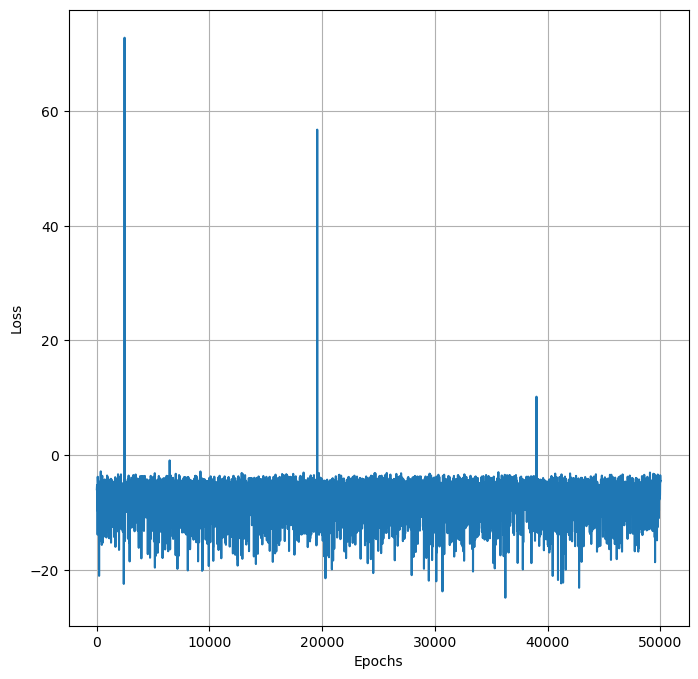

In [282]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [295]:
xs = pd.read_csv('Data/S1/xs.csv', header=None)
charts = pd.read_csv('Data/S1/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [296]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=100)

In [297]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.194733e+01 | T: ((Array([0.00450174], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.059431e+01 | T: ((Array([0.01445927], dtype=float32), Array(0.219919, dtype=float32)), Array([1., 0.], dtype=float32))
Final 1 | T: 1.059431e+01 | T: (Array([0.01445927], dtype=float32), Array(0.219919, dtype=float32))
Step 0 | T: 1.194733e+01 | T: ((Array([0.00450174], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.059431e+01 | T: ((Array([0.01445927], dtype=float32), Array(0.219919, dtype=float32)), Array([1., 0.], dtype=float32))
Step 2 | T: 9.445828e+00 | T: ((Array([0.02435014], dtype=float32), Array(0.22971171, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 8.467698e+00 | T: ((Array([0.03415324], dtype=float32), Array(0.23933935, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 7.631576e+00 | T: ((Array([0.04385026], dtype=float32), Array(0.24876963, dtype=fl

Step 58 | T: 1.086616e+00 | T: ((Array([0.373483], dtype=float32), Array(0.45866743, dtype=float32)), Array([1., 0.], dtype=float32))
Step 59 | T: 1.072419e+00 | T: ((Array([0.37749732], dtype=float32), Array(0.4597113, dtype=float32)), Array([1., 0.], dtype=float32))
Step 60 | T: 1.058598e+00 | T: ((Array([0.38148245], dtype=float32), Array(0.46071854, dtype=float32)), Array([1., 0.], dtype=float32))
Step 61 | T: 1.045132e+00 | T: ((Array([0.38543954], dtype=float32), Array(0.46169052, dtype=float32)), Array([1., 0.], dtype=float32))
Step 62 | T: 1.032004e+00 | T: ((Array([0.3893697], dtype=float32), Array(0.4626285, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.019195e+00 | T: ((Array([0.39327395], dtype=float32), Array(0.46353376, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.006691e+00 | T: ((Array([0.39715323], dtype=float32), Array(0.46440738, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 9.944760e-01 | T: ((Array([0.4010085], d

In [298]:
def gradt_log_opt(x,y,t):
    
    s1_val = M.grady_log_hk(x,y,t)
    s2_val = jacfwdx(lambda y: M.grady_log_hk(x,y,t))(y)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

In [299]:
diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t), s2_model = gradt_log_opt, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]))

In [300]:
mu_smchart = M.F((mu_sm[0][-1], mu_sm[1][-1]))

In [301]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_smchart), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.6939 0.7201 )
T = 0.9978


In [302]:
mu_bridge = M.F((mu_bridgex[-1], mu_bridgechart[-1]))

In [303]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridge), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.8670 0.4984 )
T = 0.4805


In [304]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 1.0000 0.0002 )
T = 0.0716


In [315]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1]):.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.5f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1]):.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.5f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.78229 
 -T error = 0.92626
Bridge Diffusion mean: 
 -mean error = 0.00017 
 -T error = 0.40888


In [31]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

295 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
%timeit M.diffusion_mean(X_obs,num_steps=100, N=1)

Step 0 | T: 1.556140e+01 | T: ((Array([-0.13024218], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.384183e+01 | T: ((Array([-0.12028404], dtype=float32), Array(0.21992145, dtype=float32)), Array([1., 0.], dtype=float32))
Step 2 | T: 1.237897e+01 | T: ((Array([-0.11039155], dtype=float32), Array(0.22972058, dtype=float32)), Array([1., 0.], dtype=float32))
Step 3 | T: 1.113019e+01 | T: ((Array([-0.1005855], dtype=float32), Array(0.2393599, dtype=float32)), Array([1., 0.], dtype=float32))
Step 4 | T: 1.006012e+01 | T: ((Array([-0.0908839], dtype=float32), Array(0.24880826, dtype=float32)), Array([1., 0.], dtype=float32))
Step 5 | T: 9.139505e+00 | T: ((Array([-0.08130208], dtype=float32), Array(0.25804043, dtype=float32)), Array([1., 0.], dtype=float32))
Step 6 | T: 8.344177e+00 | T: ((Array([-0.07185281], dtype=float32), Array(0.2670365, dtype=float32)), Array([1., 0.], dtype=float32))
Step 7 | T: 7.654189e+00 | T: ((Array([-0.06254657],

Step 62 | T: 1.419348e+00 | T: ((Array([0.25741065], dtype=float32), Array(0.47311848, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.402293e+00 | T: ((Array([0.26137638], dtype=float32), Array(0.47427982, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.385663e+00 | T: ((Array([0.2653171], dtype=float32), Array(0.475411, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.369438e+00 | T: ((Array([0.26923373], dtype=float32), Array(0.47651306, dtype=float32)), Array([1., 0.], dtype=float32))
Step 66 | T: 1.353597e+00 | T: ((Array([0.27312708], dtype=float32), Array(0.47758704, dtype=float32)), Array([1., 0.], dtype=float32))
Step 67 | T: 1.338125e+00 | T: ((Array([0.27699795], dtype=float32), Array(0.47863388, dtype=float32)), Array([1., 0.], dtype=float32))
Step 68 | T: 1.323005e+00 | T: ((Array([0.28084713], dtype=float32), Array(0.47965446, dtype=float32)), Array([1., 0.], dtype=float32))
Step 69 | T: 1.308221e+00 | T: ((Array([0.2846753],

Step 25 | T: 2.882330e+00 | T: ((Array([0.07728496], dtype=float32), Array(0.38890606, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 2.789116e+00 | T: ((Array([0.08361785], dtype=float32), Array(0.39307362, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 2.702716e+00 | T: ((Array([0.08982517], dtype=float32), Array(0.39706972, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 2.622452e+00 | T: ((Array([0.0959115], dtype=float32), Array(0.4009021, dtype=float32)), Array([1., 0.], dtype=float32))
Step 29 | T: 2.547718e+00 | T: ((Array([0.1018814], dtype=float32), Array(0.40457824, dtype=float32)), Array([1., 0.], dtype=float32))
Step 30 | T: 2.477981e+00 | T: ((Array([0.1077394], dtype=float32), Array(0.4081054, dtype=float32)), Array([1., 0.], dtype=float32))
Step 31 | T: 2.412769e+00 | T: ((Array([0.11348994], dtype=float32), Array(0.41149062, dtype=float32)), Array([1., 0.], dtype=float32))
Step 32 | T: 2.351662e+00 | T: ((Array([0.11913741], 

Step 88 | T: 1.076424e+00 | T: ((Array([0.35411316], dtype=float32), Array(0.49555457, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.066236e+00 | T: ((Array([0.3576207], dtype=float32), Array(0.49616033, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.056208e+00 | T: ((Array([0.3611154], dtype=float32), Array(0.4967506, dtype=float32)), Array([1., 0.], dtype=float32))
Step 91 | T: 1.046333e+00 | T: ((Array([0.3645975], dtype=float32), Array(0.4973256, dtype=float32)), Array([1., 0.], dtype=float32))
Step 92 | T: 1.036608e+00 | T: ((Array([0.36806718], dtype=float32), Array(0.49788558, dtype=float32)), Array([1., 0.], dtype=float32))
Step 93 | T: 1.027030e+00 | T: ((Array([0.37152457], dtype=float32), Array(0.4984308, dtype=float32)), Array([1., 0.], dtype=float32))
Step 94 | T: 1.017593e+00 | T: ((Array([0.37496987], dtype=float32), Array(0.49896142, dtype=float32)), Array([1., 0.], dtype=float32))
Step 95 | T: 1.008293e+00 | T: ((Array([0.37840325], d

Step 50 | T: 1.667072e+00 | T: ((Array([0.20745276], dtype=float32), Array(0.45632863, dtype=float32)), Array([1., 0.], dtype=float32))
Step 51 | T: 1.642617e+00 | T: ((Array([0.21181345], dtype=float32), Array(0.457966, dtype=float32)), Array([1., 0.], dtype=float32))
Step 52 | T: 1.619001e+00 | T: ((Array([0.21613283], dtype=float32), Array(0.45955345, dtype=float32)), Array([1., 0.], dtype=float32))
Step 53 | T: 1.596170e+00 | T: ((Array([0.22041275], dtype=float32), Array(0.46109325, dtype=float32)), Array([1., 0.], dtype=float32))
Step 54 | T: 1.574079e+00 | T: ((Array([0.2246549], dtype=float32), Array(0.4625875, dtype=float32)), Array([1., 0.], dtype=float32))
Step 55 | T: 1.552683e+00 | T: ((Array([0.22886093], dtype=float32), Array(0.46403822, dtype=float32)), Array([1., 0.], dtype=float32))
Step 56 | T: 1.531941e+00 | T: ((Array([0.23303238], dtype=float32), Array(0.46544728, dtype=float32)), Array([1., 0.], dtype=float32))
Step 57 | T: 1.511817e+00 | T: ((Array([0.23717068],

Step 10 | T: 6.065063e+00 | T: ((Array([-0.03556131], dtype=float32), Array(0.3004177, dtype=float32)), Array([1., 0.], dtype=float32))
Step 11 | T: 5.657508e+00 | T: ((Array([-0.02689395], dtype=float32), Array(0.30808225, dtype=float32)), Array([1., 0.], dtype=float32))
Step 12 | T: 5.296598e+00 | T: ((Array([-0.01839517], dtype=float32), Array(0.31547198, dtype=float32)), Array([1., 0.], dtype=float32))
Step 13 | T: 4.975773e+00 | T: ((Array([-0.01006602], dtype=float32), Array(0.32258916, dtype=float32)), Array([1., 0.], dtype=float32))
Step 14 | T: 4.689525e+00 | T: ((Array([-0.00190655], dtype=float32), Array(0.32943752, dtype=float32)), Array([1., 0.], dtype=float32))
Step 15 | T: 4.433213e+00 | T: ((Array([0.00608404], dtype=float32), Array(0.33602205, dtype=float32)), Array([1., 0.], dtype=float32))
Step 16 | T: 4.202914e+00 | T: ((Array([0.01390731], dtype=float32), Array(0.3423486, dtype=float32)), Array([1., 0.], dtype=float32))
Step 17 | T: 3.995296e+00 | T: ((Array([0.021

Step 73 | T: 1.252176e+00 | T: ((Array([0.29979077], dtype=float32), Array(0.48439133, dtype=float32)), Array([1., 0.], dtype=float32))
Step 74 | T: 1.238876e+00 | T: ((Array([0.30352318], dtype=float32), Array(0.4852704, dtype=float32)), Array([1., 0.], dtype=float32))
Step 75 | T: 1.225838e+00 | T: ((Array([0.30723807], dtype=float32), Array(0.48612818, dtype=float32)), Array([1., 0.], dtype=float32))
Step 76 | T: 1.213054e+00 | T: ((Array([0.31093588], dtype=float32), Array(0.48696518, dtype=float32)), Array([1., 0.], dtype=float32))
Step 77 | T: 1.200513e+00 | T: ((Array([0.31461704], dtype=float32), Array(0.48778194, dtype=float32)), Array([1., 0.], dtype=float32))
Step 78 | T: 1.188206e+00 | T: ((Array([0.31828198], dtype=float32), Array(0.48857898, dtype=float32)), Array([1., 0.], dtype=float32))
Step 79 | T: 1.176126e+00 | T: ((Array([0.32193106], dtype=float32), Array(0.48935673, dtype=float32)), Array([1., 0.], dtype=float32))
Step 80 | T: 1.164265e+00 | T: ((Array([0.3255646

Step 34 | T: 2.240310e+00 | T: ((Array([0.1301401], dtype=float32), Array(0.42086107, dtype=float32)), Array([1., 0.], dtype=float32))
Step 35 | T: 2.189436e+00 | T: ((Array([0.13550356], dtype=float32), Array(0.42374367, dtype=float32)), Array([1., 0.], dtype=float32))
Step 36 | T: 2.141398e+00 | T: ((Array([0.1407804], dtype=float32), Array(0.42651558, dtype=float32)), Array([1., 0.], dtype=float32))
Step 37 | T: 2.095955e+00 | T: ((Array([0.14597443], dtype=float32), Array(0.4291823, dtype=float32)), Array([1., 0.], dtype=float32))
Step 38 | T: 2.052896e+00 | T: ((Array([0.15108931], dtype=float32), Array(0.43174902, dtype=float32)), Array([1., 0.], dtype=float32))
Step 39 | T: 2.012025e+00 | T: ((Array([0.1561286], dtype=float32), Array(0.43422073, dtype=float32)), Array([1., 0.], dtype=float32))
Step 40 | T: 1.973169e+00 | T: ((Array([0.16109572], dtype=float32), Array(0.43660215, dtype=float32)), Array([1., 0.], dtype=float32))
Step 41 | T: 1.936169e+00 | T: ((Array([0.16599394],

Step 95 | T: 1.008293e+00 | T: ((Array([0.3784033], dtype=float32), Array(0.49947765, dtype=float32)), Array([1., 0.], dtype=float32))
Step 96 | T: 9.991281e-01 | T: ((Array([0.38182488], dtype=float32), Array(0.49997976, dtype=float32)), Array([1., 0.], dtype=float32))
Step 97 | T: 9.900938e-01 | T: ((Array([0.3852348], dtype=float32), Array(0.5004679, dtype=float32)), Array([1., 0.], dtype=float32))
Step 98 | T: 9.811863e-01 | T: ((Array([0.38863322], dtype=float32), Array(0.50094223, dtype=float32)), Array([1., 0.], dtype=float32))
Step 99 | T: 9.724031e-01 | T: ((Array([0.39202026], dtype=float32), Array(0.501403, dtype=float32)), Array([1., 0.], dtype=float32))
Final 99 | T: 9.724031e-01 | T: (Array([0.39202026], dtype=float32), Array(0.501403, dtype=float32))
Step 0 | T: 1.556140e+01 | T: ((Array([-0.13024218], dtype=float32), Array(0.20999993, dtype=float32)), Array([1., 0.], dtype=float32))
Step 1 | T: 1.384183e+01 | T: ((Array([-0.12028404], dtype=float32), Array(0.21992145, d

Step 58 | T: 1.492276e+00 | T: ((Array([0.24127722], dtype=float32), Array(0.46814737, dtype=float32)), Array([1., 0.], dtype=float32))
Step 59 | T: 1.473288e+00 | T: ((Array([0.2453533], dtype=float32), Array(0.46944162, dtype=float32)), Array([1., 0.], dtype=float32))
Step 60 | T: 1.454821e+00 | T: ((Array([0.24940014], dtype=float32), Array(0.47070065, dtype=float32)), Array([1., 0.], dtype=float32))
Step 61 | T: 1.436850e+00 | T: ((Array([0.2534189], dtype=float32), Array(0.47192585, dtype=float32)), Array([1., 0.], dtype=float32))
Step 62 | T: 1.419348e+00 | T: ((Array([0.25741065], dtype=float32), Array(0.4731185, dtype=float32)), Array([1., 0.], dtype=float32))
Step 63 | T: 1.402293e+00 | T: ((Array([0.26137638], dtype=float32), Array(0.47427985, dtype=float32)), Array([1., 0.], dtype=float32))
Step 64 | T: 1.385663e+00 | T: ((Array([0.2653171], dtype=float32), Array(0.47541103, dtype=float32)), Array([1., 0.], dtype=float32))
Step 65 | T: 1.369437e+00 | T: ((Array([0.2692337], 

Step 21 | T: 3.340694e+00 | T: ((Array([0.0506064], dtype=float32), Array(0.37036142, dtype=float32)), Array([1., 0.], dtype=float32))
Step 22 | T: 3.211235e+00 | T: ((Array([0.05748706], dtype=float32), Array(0.37529507, dtype=float32)), Array([1., 0.], dtype=float32))
Step 23 | T: 3.092440e+00 | T: ((Array([0.06422409], dtype=float32), Array(0.3800249, dtype=float32)), Array([1., 0.], dtype=float32))
Step 24 | T: 2.983144e+00 | T: ((Array([0.07082188], dtype=float32), Array(0.38455918, dtype=float32)), Array([1., 0.], dtype=float32))
Step 25 | T: 2.882331e+00 | T: ((Array([0.07728495], dtype=float32), Array(0.38890606, dtype=float32)), Array([1., 0.], dtype=float32))
Step 26 | T: 2.789115e+00 | T: ((Array([0.08361784], dtype=float32), Array(0.39307362, dtype=float32)), Array([1., 0.], dtype=float32))
Step 27 | T: 2.702717e+00 | T: ((Array([0.08982515], dtype=float32), Array(0.39706972, dtype=float32)), Array([1., 0.], dtype=float32))
Step 28 | T: 2.622452e+00 | T: ((Array([0.09591148

Step 83 | T: 1.129919e+00 | T: ((Array([0.33637586], dtype=float32), Array(0.49228343, dtype=float32)), Array([1., 0.], dtype=float32))
Step 84 | T: 1.118862e+00 | T: ((Array([0.33995074], dtype=float32), Array(0.49297094, dtype=float32)), Array([1., 0.], dtype=float32))
Step 85 | T: 1.107988e+00 | T: ((Array([0.34351167], dtype=float32), Array(0.4936415, dtype=float32)), Array([1., 0.], dtype=float32))
Step 86 | T: 1.097295e+00 | T: ((Array([0.3470589], dtype=float32), Array(0.49429542, dtype=float32)), Array([1., 0.], dtype=float32))
Step 87 | T: 1.086775e+00 | T: ((Array([0.35059267], dtype=float32), Array(0.494933, dtype=float32)), Array([1., 0.], dtype=float32))
Step 88 | T: 1.076424e+00 | T: ((Array([0.35411322], dtype=float32), Array(0.49555457, dtype=float32)), Array([1., 0.], dtype=float32))
Step 89 | T: 1.066236e+00 | T: ((Array([0.35762075], dtype=float32), Array(0.49616033, dtype=float32)), Array([1., 0.], dtype=float32))
Step 90 | T: 1.056208e+00 | T: ((Array([0.36111546],

Step 46 | T: 1.774482e+00 | T: ((Array([0.18955693], dtype=float32), Array(0.4492298, dtype=float32)), Array([1., 0.], dtype=float32))
Step 47 | T: 1.746056e+00 | T: ((Array([0.19410312], dtype=float32), Array(0.45109233, dtype=float32)), Array([1., 0.], dtype=float32))
Step 48 | T: 1.718727e+00 | T: ((Array([0.19859968], dtype=float32), Array(0.45289442, dtype=float32)), Array([1., 0.], dtype=float32))
Step 49 | T: 1.692422e+00 | T: ((Array([0.20304884], dtype=float32), Array(0.45463896, dtype=float32)), Array([1., 0.], dtype=float32))
Step 50 | T: 1.667072e+00 | T: ((Array([0.20745276], dtype=float32), Array(0.45632863, dtype=float32)), Array([1., 0.], dtype=float32))
Step 51 | T: 1.642617e+00 | T: ((Array([0.21181345], dtype=float32), Array(0.457966, dtype=float32)), Array([1., 0.], dtype=float32))
Step 52 | T: 1.619001e+00 | T: ((Array([0.21613283], dtype=float32), Array(0.45955345, dtype=float32)), Array([1., 0.], dtype=float32))
Step 53 | T: 1.596170e+00 | T: ((Array([0.22041275]

# n-Sphere

## Defining Manifold and Loading Score

In [154]:
N = 20

In [155]:
M = nSphere(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
initialize(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [93]:
file_path = 'scores/S'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [94]:
loss = jnp.load('scores/S'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  1390


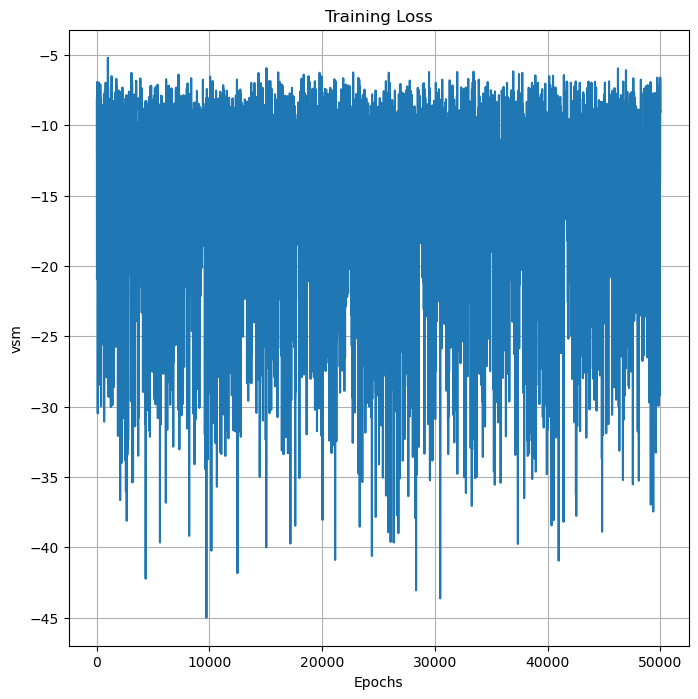

In [21]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [22]:
xs = pd.read_csv('Data/S'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/S'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [23]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")

In [24]:
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [25]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.042939e+01 | T: ((Array([-4.153821e-09, -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 1 | T: 9.547485e+00 | T: ((Array([1.6526341e-05, 9.7911786e-03], dtype=float32), Array(0.2199444, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Final 1 | T: 9.547485e+00 | T: (Array([1.6526341e-05, 9.7911786e-03], dtype=float32), Array(0.2199444, dtype=float32))
Step 0 | T: 1.042908e+01 | T: ((Array([-4.153821e-09, -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 1 | T: 9.547361e+00 | T: ((Array([1.6842194e-05, 9.7911442e-03], dtype=float32), Array(0.2199444, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 2 | T: 8.492002e+00 | T: ((Array([0.00336031, 0.01939663], dtype=float32), Array(0.22977996, dtype=float32)), Array([ 0.26764584, -0.22893406,

Step 44 | T: 1.199940e+00 | T: ((Array([-0.01812116,  0.08775882], dtype=float32), Array(0.4527328, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 45 | T: 1.185442e+00 | T: ((Array([-0.01973556,  0.08684929], dtype=float32), Array(0.45507914, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 46 | T: 1.171752e+00 | T: ((Array([-0.02126584,  0.08588431], dtype=float32), Array(0.4573656, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 47 | T: 1.157950e+00 | T: ((Array([-0.0227101 ,  0.08487381], dtype=float32), Array(0.4595952, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 48 | T: 1.145928e+00 | T: ((Array([-0.02406703,  0.08382822], dtype=float32), Array(0.46177095, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 49 | T: 1.133869e+00 | T: ((Array([-0.02533625,  0.08275684], dtype=float32), Array(0.4638956

Step 90 | T: 8.859409e-01 | T: ((Array([-0.03057342,  0.06103399], dtype=float32), Array(0.5264058, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 91 | T: 8.828608e-01 | T: ((Array([-0.03035113,  0.0610534 ], dtype=float32), Array(0.52758145, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 92 | T: 8.796988e-01 | T: ((Array([-0.03013689,  0.06107901], dtype=float32), Array(0.5287464, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 93 | T: 8.768717e-01 | T: ((Array([-0.02993018,  0.06110909], dtype=float32), Array(0.5299009, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 94 | T: 8.735394e-01 | T: ((Array([-0.02973253,  0.06114203], dtype=float32), Array(0.53104514, dtype=float32)), Array([ 0.11126842, -0.12337706,  0.9850469 ], dtype=float32))
Step 95 | T: 8.713099e-01 | T: ((Array([-0.02954358,  0.06117702], dtype=float32), Array(0.5321793

In [26]:
#diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = lambda x,y,t: jacfwdx(lambda y: M.grady_log_hk(x,y,t)[0])(y), method="Gradient")
diffusion_mean.initialize(M, s1_model=lambda x,y,t: M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")
mu_opt, T_opt, _, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]))

In [27]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0475 -0.0123 0.9932 )
T = 0.4682


In [28]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.1113 -0.1234 0.9850 )
T = 0.5366


In [29]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_opt[1][-1]), ")")
print(f"T = {T_opt[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0339 0.0408 0.9720 )
T = 0.4983


In [30]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.1283 
 -T error = 0.0383


In [31]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-T_opt[-1][0]):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_opt[1][-1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02938 
 -T error = 0.0300
Bridge Diffusion mean: 
 -mean error = 0.09098 
 -T error = 0.0383


In [ ]:
%timeit mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [32]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

Step 0 | T: 1.043008e+01 | T: ((Array([-4.153821e-09, -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 1 | T: 9.550106e+00 | T: ((Array([1.3698771e-05, 9.7907316e-03], dtype=float32), Array(0.21994455, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 2 | T: 8.492488e+00 | T: ((Array([0.00335489, 0.01939591], dtype=float32), Array(0.22978008, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 3 | T: 7.571478e+00 | T: ((Array([0.00828754, 0.02878044], dtype=float32), Array(0.23946565, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 4 | T: 6.776864e+00 | T: ((Array([0.01409798, 0.03790157], dtype=float32), Array(0.24896803, dtype=float32)), Array([ 0.26764584, -0.22893406,  0.9359246 ], dtype=float32))
Step 5 | T: 6.096584e+00 | T: ((Array([0.02041493, 0.04671672], dtype=float32), Array(0.25826076, 

Step 46 | T: 1.171416e+00 | T: ((Array([-0.02126118,  0.08589023], dtype=float32), Array(0.4573579, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 47 | T: 1.158250e+00 | T: ((Array([-0.02270645,  0.08488234], dtype=float32), Array(0.45958745, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 48 | T: 1.145433e+00 | T: ((Array([-0.02406423,  0.08383911], dtype=float32), Array(0.46176308, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 49 | T: 1.133214e+00 | T: ((Array([-0.02533423,  0.08276983], dtype=float32), Array(0.46388757, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 50 | T: 1.122126e+00 | T: ((Array([-0.02651681,  0.0816839 ], dtype=float32), Array(0.4659636, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 51 | T: 1.111436e+00 | T: ((Array([-0.02761236,  0.08058816], dtype=float32), Array(0.467993

Step 92 | T: 8.797777e-01 | T: ((Array([-0.03012471,  0.0610891 ], dtype=float32), Array(0.52873886, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 93 | T: 8.763884e-01 | T: ((Array([-0.0299181 ,  0.06111861], dtype=float32), Array(0.5298935, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 94 | T: 8.735876e-01 | T: ((Array([-0.02972019,  0.06115125], dtype=float32), Array(0.53103787, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 95 | T: 8.708547e-01 | T: ((Array([-0.02953075,  0.06118631], dtype=float32), Array(0.53217214, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 96 | T: 8.679372e-01 | T: ((Array([-0.02935067,  0.06122279], dtype=float32), Array(0.5332964, dtype=float32)), Array([ 0.11127572, -0.12339058,  0.98504454], dtype=float32))
Step 97 | T: 8.645270e-01 | T: ((Array([-0.02917982,  0.06125944], dtype=float32), Array(0.534410

Step 38 | T: 1.308784e+00 | T: ((Array([-0.00685037,  0.09136215], dtype=float32), Array(0.43719035, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 39 | T: 1.287764e+00 | T: ((Array([-0.00889471,  0.0910423 ], dtype=float32), Array(0.4399718, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 40 | T: 1.268612e+00 | T: ((Array([-0.0108809 ,  0.09059191], dtype=float32), Array(0.4426708, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 41 | T: 1.250240e+00 | T: ((Array([-0.0128028 ,  0.09002459], dtype=float32), Array(0.44529158, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 42 | T: 1.232628e+00 | T: ((Array([-0.0146547 ,  0.08935345], dtype=float32), Array(0.44783822, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 43 | T: 1.216527e+00 | T: ((Array([-0.01643148,  0.08859129], dtype=float32), Array(0.450314

Step 84 | T: 9.068902e-01 | T: ((Array([-0.03202119,  0.0611343 ], dtype=float32), Array(0.5191112, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 85 | T: 9.025811e-01 | T: ((Array([-0.03176777,  0.06108777], dtype=float32), Array(0.5203558, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 86 | T: 8.994032e-01 | T: ((Array([-0.03151704,  0.06105613], dtype=float32), Array(0.5215883, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 87 | T: 8.959877e-01 | T: ((Array([-0.03126983,  0.06103818], dtype=float32), Array(0.522809, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 88 | T: 8.928174e-01 | T: ((Array([-0.03102807,  0.06103219], dtype=float32), Array(0.5240182, dtype=float32)), Array([ 0.11127619, -0.12337932,  0.98504573], dtype=float32))
Step 89 | T: 8.892666e-01 | T: ((Array([-0.030792  ,  0.06103578], dtype=float32), Array(0.5252161, d

Step 30 | T: 1.531616e+00 | T: ((Array([0.01042156, 0.08747175], dtype=float32), Array(0.4113893, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 31 | T: 1.496553e+00 | T: ((Array([0.00829408, 0.08871845], dtype=float32), Array(0.41501322, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 32 | T: 1.463841e+00 | T: ((Array([0.00612778, 0.08971853], dtype=float32), Array(0.41851178, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 33 | T: 1.433515e+00 | T: ((Array([0.00393946, 0.09048586], dtype=float32), Array(0.4218912, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 34 | T: 1.405822e+00 | T: ((Array([0.00174448, 0.09103478], dtype=float32), Array(0.42515758, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 35 | T: 1.378827e+00 | T: ((Array([-0.00044349,  0.09137976], dtype=float32), Array(0.42831653, dtype=

Step 76 | T: 9.391280e-01 | T: ((Array([-0.03399592,  0.06227544], dtype=float32), Array(0.50869304, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 77 | T: 9.351838e-01 | T: ((Array([-0.03377282,  0.06204125], dtype=float32), Array(0.510046, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 78 | T: 9.307746e-01 | T: ((Array([-0.03353912,  0.06183673], dtype=float32), Array(0.5113841, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 79 | T: 9.268356e-01 | T: ((Array([-0.03329756,  0.06165957], dtype=float32), Array(0.5127079, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 80 | T: 9.224540e-01 | T: ((Array([-0.0330492 ,  0.06150889], dtype=float32), Array(0.5140176, dtype=float32)), Array([ 0.11127521, -0.12335576,  0.9850488 ], dtype=float32))
Step 81 | T: 9.183773e-01 | T: ((Array([-0.03279629,  0.06138323], dtype=float32), Array(0.51531357,

Step 21 | T: 2.007910e+00 | T: ((Array([0.02406734, 0.06311606], dtype=float32), Array(0.37197927, dtype=float32)), Array([ 0.11126844, -0.12339979,  0.9850441 ], dtype=float32))


KeyboardInterrupt: 

# n-Ellipsoid

## Defining Manifold and Loading Score

In [157]:
N = 20

In [158]:
M = Ellipsoid(N=N, params = jnp.linspace(0.5,1.0,N+1))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*N)

using M.Exp for Logarithm


In [113]:
file_path = 'scores/Ellipsoid'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if N<10:
    layers = [50,100,100,50]
elif N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [114]:
loss = jnp.load('scores/Ellipsoid'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  1370


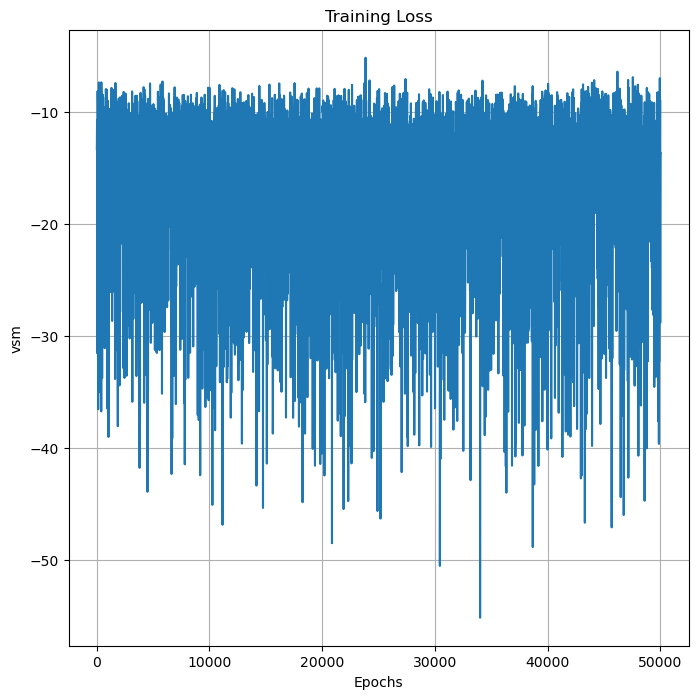

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [9]:
xs = pd.read_csv('Data/Ellipsoid'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Ellipsoid'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [10]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.01, max_iter=1000)

In [11]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 5.268708e+00 | T: ((Array([-3.620877e-10, -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 1 | T: 4.190292e+00 | T: ((Array([ 0.007237  , -0.00357153], dtype=float32), Array(0.21985073, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Final 1 | T: 4.190292e+00 | T: (Array([ 0.007237  , -0.00357153], dtype=float32), Array(0.21985073, dtype=float32))
Step 0 | T: 5.265175e+00 | T: ((Array([-3.620877e-10, -0.000000e+00], dtype=float32), Array(0.20999993, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 1 | T: 4.189316e+00 | T: ((Array([ 0.00723636, -0.00357442], dtype=float32), Array(0.21985115, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 2 | T: 3.739469e+00 | T: ((Array([ 0.01303642, -0.00961128], dtype=float32), Array(0.22955331, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974

Step 43 | T: 1.085074e+00 | T: ((Array([ 0.00573923, -0.02470205], dtype=float32), Array(0.43293473, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 44 | T: 1.083381e+00 | T: ((Array([ 0.00540811, -0.02322735], dtype=float32), Array(0.43474293, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 45 | T: 1.079116e+00 | T: ((Array([ 0.00513513, -0.02188238], dtype=float32), Array(0.43648598, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 46 | T: 1.076231e+00 | T: ((Array([ 0.00491447, -0.02066379], dtype=float32), Array(0.43816772, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 47 | T: 1.074228e+00 | T: ((Array([ 0.00474263, -0.01956882], dtype=float32), Array(0.43979144, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 48 | T: 1.065572e+00 | T: ((Array([ 0.0045969 , -0.01857383], dtype=float32), Array(0.4413

Step 89 | T: 1.032041e+00 | T: ((Array([ 0.00813252, -0.01079023], dtype=float32), Array(0.47925287, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 90 | T: 1.031971e+00 | T: ((Array([ 0.00808651, -0.01050195], dtype=float32), Array(0.47981325, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 91 | T: 1.030402e+00 | T: ((Array([ 0.00803688, -0.01021201], dtype=float32), Array(0.48036325, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 92 | T: 1.031241e+00 | T: ((Array([ 0.00798353, -0.00992064], dtype=float32), Array(0.48090363, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 93 | T: 1.030432e+00 | T: ((Array([ 0.00792649, -0.00963215], dtype=float32), Array(0.48143455, dtype=float32)), Array([-0.21094368, -0.07561798,  0.974569  ], dtype=float32))
Step 94 | T: 1.030632e+00 | T: ((Array([ 0.00786661, -0.0093506 ], dtype=float32), Array(0.4819

In [12]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0095 -0.0042 0.9994 )
T = 0.4789


In [13]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( -0.2109 -0.0756 0.9746 )
T = 0.4844


In [14]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_opt[-1][0]):.4f}")

The difference between the score and bridge:


NameError: name 'T_opt' is not defined

In [15]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/N:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/N:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.00519 
 -T error = 0.0211
Bridge Diffusion mean: 
 -mean error = 0.11276 
 -T error = 0.0156


In [194]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

KeyboardInterrupt: 

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Cylinder

## Defining Manifold and Loading Score

In [160]:
M = Cylinder(params=(1.,jnp.array([0.,0.,1.]),jnp.pi/2.))
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
x0[1]

using M.Exp for Logarithm


Array([0., 0.], dtype=float32)

In [116]:
file_path = 'scores/Cylinder/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [117]:
loss = jnp.load('scores/Cylinder/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


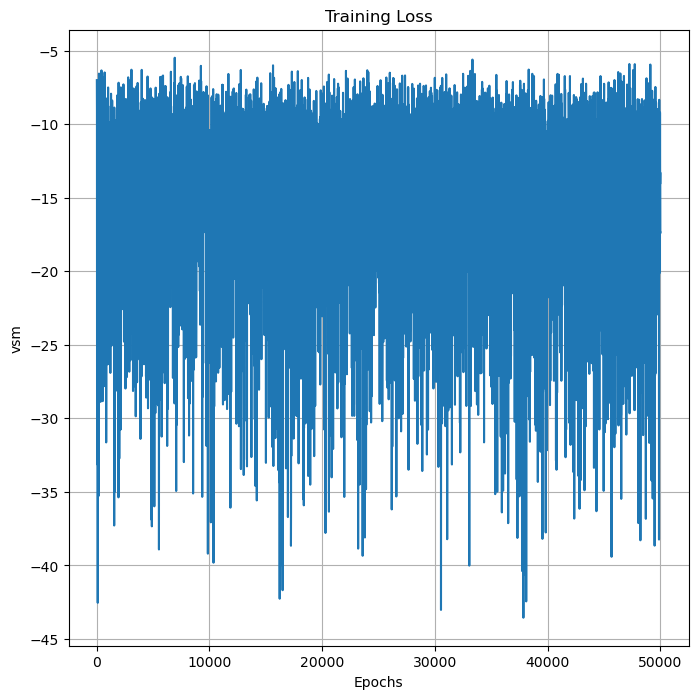

In [81]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [82]:
xs = pd.read_csv('Data/Cylinder/xs.csv', header=None)
charts = pd.read_csv('Data/Cylinder/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [83]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [84]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.130957e+01 | T: ((Array([-0.02587204,  0.06452829], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.021403e+01 | T: ((Array([-0.03275904,  0.05470097], dtype=float32), Array(0.21992894, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.021403e+01 | T: (Array([-0.03275904,  0.05470097], dtype=float32), Array(0.21992894, dtype=float32))
Step 0 | T: 1.130957e+01 | T: ((Array([-0.02587204,  0.06452829], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.021403e+01 | T: ((Array([-0.03275904,  0.05470097], dtype=float32), Array(0.21992894, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 9.283365e+00 | T: ((Array([-0.03446573,  0.04518323], dtype=float32), Array(0.2297475, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 8.488744e+00 | T: ((Array([-0.03292985,  0.03612189], dtype=float32), Array(0.23942202, dtype=float32)), Array([0., 0.], dtype=f

Step 53 | T: 2.569135e+00 | T: ((Array([-0.02585055,  0.01791908], dtype=float32), Array(0.4813849, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 2.558720e+00 | T: ((Array([-0.02608876,  0.01736902], dtype=float32), Array(0.48343876, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 2.548722e+00 | T: ((Array([-0.02631092,  0.01685355], dtype=float32), Array(0.48545206, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 2.539115e+00 | T: ((Array([-0.02650013,  0.01637699], dtype=float32), Array(0.48742664, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 2.529876e+00 | T: ((Array([-0.02664378,  0.01594271], dtype=float32), Array(0.48936433, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 2.520983e+00 | T: ((Array([-0.02673416,  0.01555317], dtype=float32), Array(0.49126676, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 2.512416e+00 | T: ((Array([-0.02676868,  0.01520993], dtype=float32), Array(0.4931355, d

In [85]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( -0.0341 0.0185 )
T = 0.5071


In [86]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5507


In [87]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0388 
 -T error = 0.0436


In [89]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.01940 
 -T error = 0.0071
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0507


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Torus

## Defining Manifold and Loading Score

In [163]:
M = Torus()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)
x0[1]

using M.Exp for Logarithm


Array([0., 0.], dtype=float32)

In [119]:
file_path = 'scores/Torus/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.emb_dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), M.F(y))), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), M.F(y))), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [120]:
loss = jnp.load('scores/Torus/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


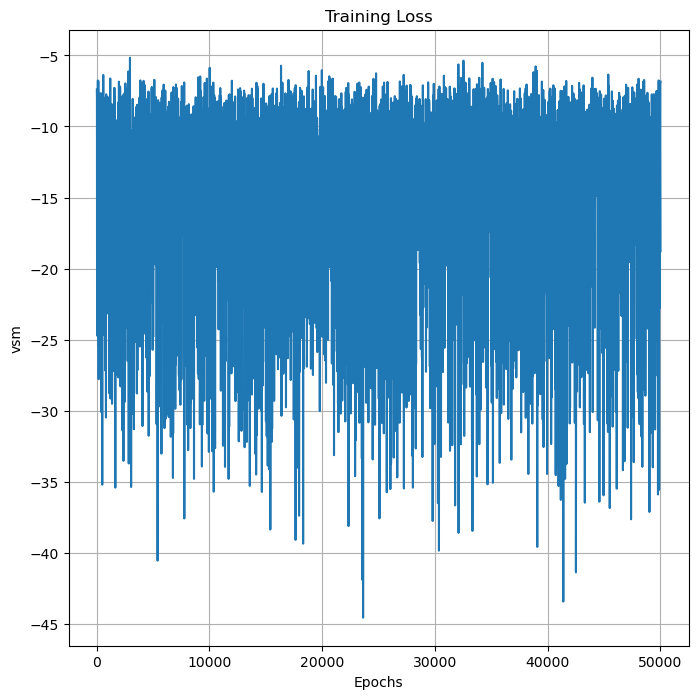

In [93]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [94]:
xs = pd.read_csv('Data/Torus/xs.csv', header=None)
charts = pd.read_csv('Data/Torus/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [95]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.1, max_iter=100)

In [96]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

Step 0 | T: 1.453338e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265824e+01 | T: ((Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32)), Array([0., 0.], dtype=float32))
Final 1 | T: 1.265824e+01 | T: (Array([-0.17184542, -0.01500721], dtype=float32), Array(0.219913, dtype=float32))
Step 0 | T: 1.453340e+01 | T: ((Array([-0.18177876, -0.00945805], dtype=float32), Array(0.20999993, dtype=float32)), Array([0., 0.], dtype=float32))
Step 1 | T: 1.265763e+01 | T: ((Array([-0.17184542, -0.015028  ], dtype=float32), Array(0.21991298, dtype=float32)), Array([0., 0.], dtype=float32))
Step 2 | T: 1.108802e+01 | T: ((Array([-0.16201945, -0.02065388], dtype=float32), Array(0.22969085, dtype=float32)), Array([0., 0.], dtype=float32))
Step 3 | T: 9.771928e+00 | T: ((Array([-0.15233807, -0.02273714], dtype=float32), Array(0.2392931, dtype=float32)), Array([0., 0.], dtype=float

Step 53 | T: 1.572088e+00 | T: ((Array([ 0.01941139, -0.01369051], dtype=float32), Array(0.46345207, dtype=float32)), Array([0., 0.], dtype=float32))
Step 54 | T: 1.560797e+00 | T: ((Array([ 0.01918913, -0.0135701 ], dtype=float32), Array(0.4653291, dtype=float32)), Array([0., 0.], dtype=float32))
Step 55 | T: 1.549640e+00 | T: ((Array([ 0.01893759, -0.01354981], dtype=float32), Array(0.46717286, dtype=float32)), Array([0., 0.], dtype=float32))
Step 56 | T: 1.538876e+00 | T: ((Array([ 0.01866033, -0.0136252 ], dtype=float32), Array(0.4689849, dtype=float32)), Array([0., 0.], dtype=float32))
Step 57 | T: 1.528749e+00 | T: ((Array([ 0.01836071, -0.01377137], dtype=float32), Array(0.4707667, dtype=float32)), Array([0., 0.], dtype=float32))
Step 58 | T: 1.518717e+00 | T: ((Array([ 0.01804182, -0.01395113], dtype=float32), Array(0.47251964, dtype=float32)), Array([0., 0.], dtype=float32))
Step 59 | T: 1.508847e+00 | T: ((Array([ 0.01770659, -0.01414127], dtype=float32), Array(0.47424498, dt

In [97]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0266 -0.0372 )
T = 0.5016


In [98]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5290


In [99]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0457 
 -T error = 0.0274


In [101]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1])/2:.5f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1])/2:.5f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.02286 
 -T error = 0.0016
Bridge Diffusion mean: 
 -mean error = 0.00000 
 -T error = 0.0290


In [ ]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# Hyperbolic Parabolid

## Defining Manifold and Loading Score

In [165]:
M = HypParaboloid()
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([0.]*2)

using M.Exp for Logarithm


In [122]:
file_path = 'scores/HypParaboloid/'+ loss_type + '/'
state = model_loader.load_model(file_path)
layers = [50, 100, 100, 50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [123]:
loss = jnp.load('scores/HypParaboloid/' + loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  50010


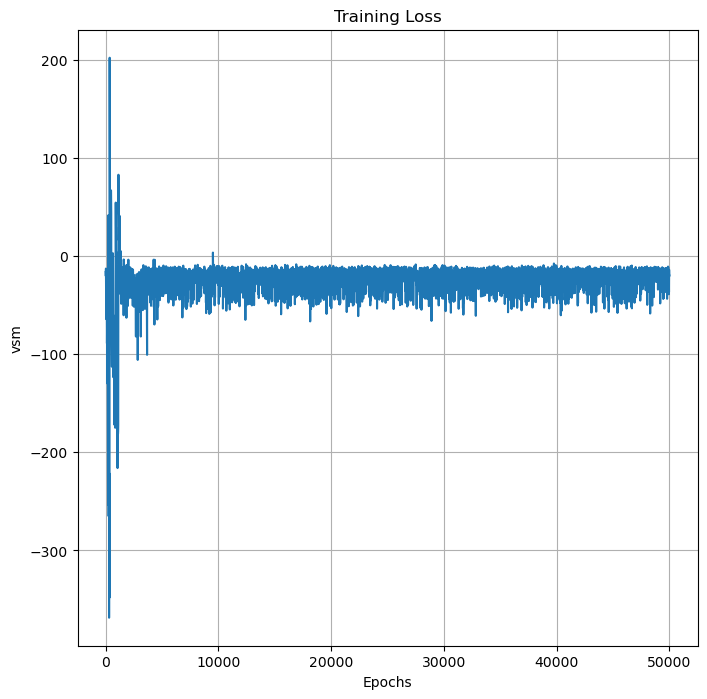

In [105]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel(loss_type)
ax.set_title('Training Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [106]:
xs = pd.read_csv('Data/HypParaboloid/xs.csv', header=None)
charts = pd.read_csv('Data/HypParaboloid/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [108]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=1000)

In [109]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [110]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[1][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 0.0000 )
T = 1.0000


In [111]:
print(f"Bridge Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_bridgechart[-1]), ")")
print(f"T = {T_bridge[-1]:.4f}")

Bridge Riemannian Diffusion Mean:
mu = ( 0.0000 0.0000 )
T = 0.5290


In [112]:
print("The difference between the score and bridge:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(mu_bridgechart[-1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-T_sm[-1][0]):.4f}")

The difference between the score and bridge:
Score Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.4710


In [113]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_sm[1][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")
print(f"Bridge Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[1]-mu_bridgechart[-1]):.4f} \n -T error = {jnp.abs(T_bridge[-1]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.5000
Bridge Diffusion mean: 
 -mean error = 0.0000 
 -T error = 0.0290


In [253]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

426 ms ± 7.06 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit M.diffusion_mean(X_obs,num_steps=100)

# SPDN

## Defining Manifold and Loading Score

In [173]:
N = 5

In [174]:
M = SPDN(N=N)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords([10.]*(N*(N+1)//2))

using M.Exp for Logarithm


In [176]:
M.F(x0).reshape(5,5)

Array([[100., 100., 100., 100., 100.],
       [100., 200., 200., 200., 200.],
       [100., 200., 300., 300., 300.],
       [100., 200., 300., 400., 400.],
       [100., 200., 300., 400., 500.]], dtype=float32)

In [134]:
file_path = 'scores/SPDN'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
from jax import jacfwd
if N*N<10:
    layers = [50,100,100,50]
elif N*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.emb_dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.emb_dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t))))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[1], y[1], t)))
    s2_val = ggrady_log(x,y,t)
    s1_proj = jnp.dot(M.invJF((M.F(y), y[1])), s1_val)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_proj,jacfwdx(M.logAbsDet)((y[0],M.F(y))).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    #ggrad = jacfwdx(lambda y: to_TMx(M, M.F(y), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    ggrad = jacfwdx(lambda y: jnp.dot(M.invJF((M.F(y), y[1])), s1.apply(state.params,rng_key, jnp.hstack((M.F(x), M.F(y), t)))))(y)
    
    return ggrad

## Loading Loss

In [135]:
loss = jnp.load('scores/SPDN'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  40


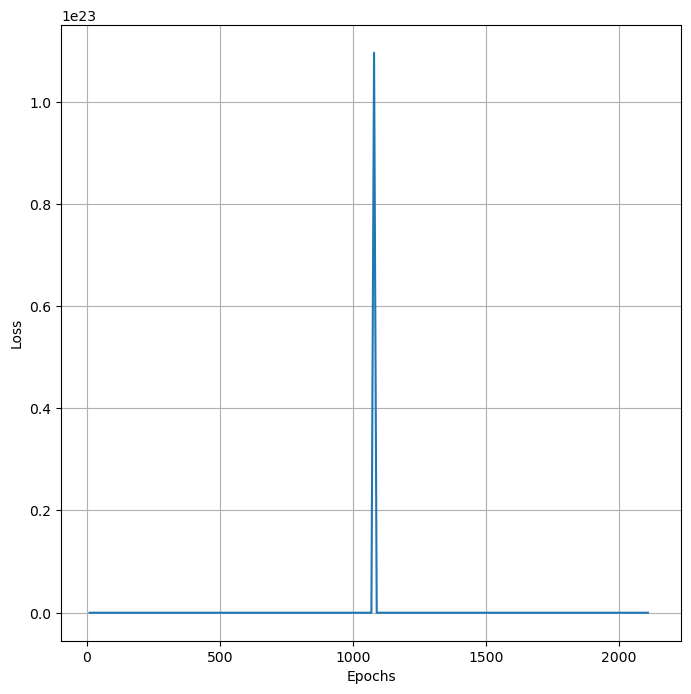

In [37]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [38]:
xs = pd.read_csv('Data/SPDN'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/SPDN'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values)[~jnp.isnan(xs.values).any(axis=1)], jnp.array(charts.values)[~jnp.isnan(xs.values).any(axis=1)])

In [39]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), 
                                     step_size=0.01, max_iter=100)

In [40]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [139]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.0884 
 -T error = 0.0103


In [140]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

1min 7s ± 2.18 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Landmarks

## Defining Manifold and Loading Score

In [182]:
N = 5

In [183]:
M = Landmarks(N=N,m=2)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.linspace(5.0,-5.0,M.N))).T.flatten())
x0 = M.coords(jnp.vstack((jnp.linspace(-5.0,5.0,M.N),jnp.zeros(M.N))).T.flatten())
if N >=10:
    with open('../Data/landmarks/Papilonidae/Papilionidae_landmarks.txt', 'r') as the_file:
        all_data = [line.strip() for line in the_file.readlines()]

        x1 = jnp.array([float(x) for x in all_data[0].split()[2:]])
        x2 = jnp.array([float(x) for x in all_data[1].split()[2:]])

        x0 = M.coords(jnp.vstack((x1[::len(x1)//N],x2[::len(x2)//N])).T.flatten())

using M.Exp for Logarithm


In [184]:
x0[0].reshape(-1,2)

Array([[-5. ,  0. ],
       [-2.5,  0. ],
       [ 0. ,  0. ],
       [ 2.5,  0. ],
       [ 5. ,  0. ]], dtype=float32)

In [150]:
file_path = 'scores/Landmarks'+str(N)+'/'+ loss_type + '/'
state = model_loader.load_model(file_path)
if 2*N<10:
    layers = [50,100,100,50]
elif 2*N<50:
    layers = [50,100,200,200,100,50]
else:
    layers = [50,100,200,400,400,200,100,50]
s1 = hk.transform(lambda x: models.MLP_s1(dim=M.dim, layers=layers)(x))
s2 = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=M.dim, r = max(M.dim//2,1))(x))
rng_key = jax.random.PRNGKey(2712)
def grady_log(x,y,t):
    
    return s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [151]:
loss = jnp.load('scores/Landmarks'+str(N)+'/'+ loss_type + '/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  290


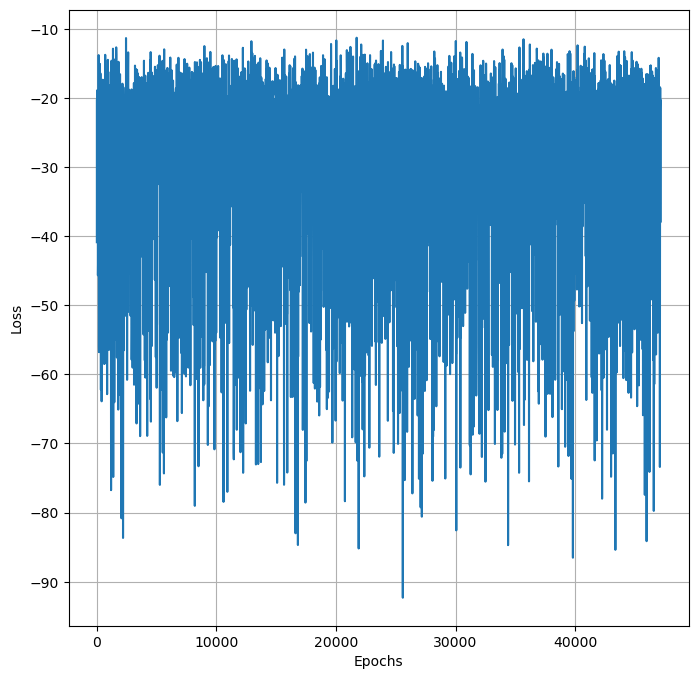

In [24]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [25]:
xs = pd.read_csv('Data/Landmarks'+str(N)+'/xs.csv', header=None)
charts = pd.read_csv('Data/Landmarks'+str(N)+'/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [179]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.1, max_iter=100)

In [27]:
# run once to compile
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=2, N=1)
# run MLE0
(thetas,chart,log_likelihood,log_likelihoods,mu_bridge) = M.diffusion_mean(X_obs,num_steps=100, N=1)

mu_bridgex, T_bridge, mu_bridgechart = zip(*mu_bridge)
mu_bridgex, mu_bridghechart = jnp.stack(mu_bridgex), jnp.stack(mu_bridgechart)
T_bridge = jnp.stack(T_bridge)

ValueError: The user-provided objective function must return a scalar value.

In [180]:
print(f"Score Matching Riemannian Diffusion Mean:")
print("mu = (", ' '.join("{:.4f}".format(x) for x in mu_sm[0][-1]), ")")
print(f"T = {T_sm[-1][0]:.4f}")

Score Matching Riemannian Diffusion Mean:
mu = ( 970.9875 -531.0389 786.9651 -282.0235 538.2798 -99.2970 410.0120 -249.2059 488.9926 -538.1085 720.0261 -594.9356 538.8295 -770.3947 601.4021 -980.1694 754.7902 -1085.8058 904.4723 -920.4603 1269.9738 -604.0638 1558.9043 -538.2828 1647.0077 -239.7993 1467.5654 -127.9185 1213.7883 -327.6476 1045.0359 -735.9542 1099.6089 -994.5779 1279.8562 -1091.9882 1441.1367 -973.8962 1434.9781 -733.2339 )
T = 0.5629


In [181]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 0.1806 
 -T error = 0.0629


In [182]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

26.2 s ± 1.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


# MNIST

## Defining Manifold and Loading Score

In [77]:
s1_path = ''.join(('scores/MNIST/',loss_type,'/'))
s2_path = 'scores/MNIST/s2/'

ds = load_mnist("train", 100, 2712)

state = load_model('ManLearn/models/MNIST/VAE/')
F = lambda x: mnist_decoder.apply(state.params, state.rng_key, x[0]).reshape(-1)

M = Latent(F=F,dim=2,emb_dim=28*28,invF=None)
jstoch.Brownian_coords(M)
jstat.diffusion_mean(M)

N_dim = M.dim
x0 = mnist_encoder.apply(state.params, state.rng_key, next(ds).image)
x0 = M.coords(x0[0])

layers = [50,100,200,400,400,200,100,50]

s1_model = hk.transform(lambda x: models.MLP_s1(dim=N_dim, layers=layers)(x))
s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                dim=N_dim, r = max(N_dim//2,1))(x))

using M.Exp for Logarithm


2023-10-11 17:23:29.552717: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [78]:
rng_key = jax.random.PRNGKey(2712)
s1_state = load_model(s1_path)
def grady_log(x,y,t):
    
    return s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))

def gradt_log(x,y,t):
    
    s1_val = s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t)))
    s2_val = ggrady_log(x,y,t)
    
    div = jnp.trace(s2_val)+.5*jnp.dot(s1_val,jacfwdx(M.logAbsDet)(y).squeeze())
    
    return 0.5*(jnp.dot(s1_val, s1_val)+div)

def ggrady_log(x,y,t):
    
    ggrad = jacfwdx(lambda y: s1.apply(s1_state.params,rng_key, jnp.hstack((x[0], y[0], t))))(y)
    
    return ggrad

## Loading Loss

In [79]:
loss = jnp.load('scores/MNIST/'+loss_type+'/loss_arrays.npy')
print("Number of Epochs: ", len(loss)*10)

Number of Epochs:  90


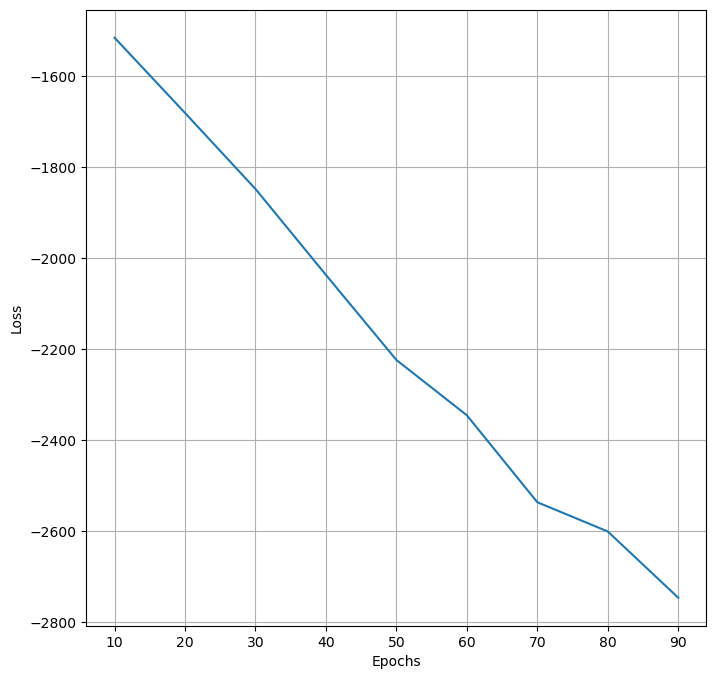

In [80]:
fig = plt.figure(figsize=(8,8))

#R2
ax = fig.add_subplot(1,1,1)
ax.plot(10*jnp.arange(1,len(loss)+1, 1), loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.grid(True)

## Estimating Diffusion t-Mean

In [81]:
xs = pd.read_csv('Data/VAE_MNIST/xs.csv', header=None)
charts = pd.read_csv('Data/VAE_MNIST/chart.csv', header=None)
X_obs = (jnp.array(xs.values), jnp.array(charts.values))

In [82]:
diffusion_mean.initialize(M, s1_model=grady_log, s2_model = gradt_log, method="Gradient")
mu_sm, T_sm, gradx_sm, _ = M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.2]), 
                                     step_size=0.01, max_iter=100)

In [83]:
print("The Error estimates are:")
print(f"Score Diffusion mean: \n -mean error = {jnp.linalg.norm(x0[0]-mu_sm[0][-1]):.4f} \n -T error = {jnp.abs(T_sm[-1][0]-0.5):.4f}")

The Error estimates are:
Score Diffusion mean: 
 -mean error = 12.4434 
 -T error = 0.5000


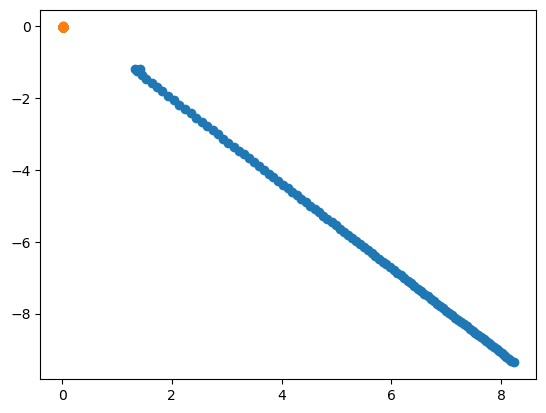

In [84]:
plt.scatter(mu_sm[0][:,0], mu_sm[0][:,1])
plt.scatter(X_obs[0][:,0], X_obs[0][:,1])

In [427]:
%timeit M.sm_dmxt(X_obs, (X_obs[0][0], X_obs[1][0]), jnp.array([0.1]), step_size=0.01, max_iter=100)

26 s ± 197 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [86]:
x0 = mnist_decoder.apply(state.params, state.rng_key, mu_sm[0][-1])

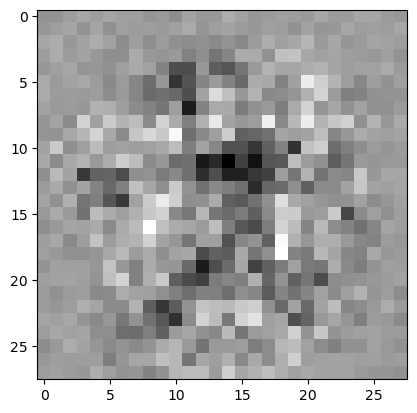

In [91]:
plt.imshow(x0[0], cmap=plt.cm.binary)